## Code adapted from  haliphinx /ORB-Mono-KITTI-Evaluation 

### Alignment and Absolute trajectory error

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def gen_data(ground_time, res_time, ground_data):
    ground_time = ground_time
    res_time = res_time
    ground_data = ground_data

    time_mark = 0
    time = []

    data_1 = []

    for num in range(len(ground_data)):
        data_1.append(np.concatenate(([ground_time[num]], ground_data[num])))

    data_2 = []




    for num in range(len(res_time)):
        while not np.allclose(data_1[time_mark][0], res_time[num][0]):
            time_mark+=1
        data_2.append(data_1[time_mark])

    return data_2


def get_coo(data):
    points = [[],[],[]]
    for num in range(len(data)):
        points[0].append(data[num][4])
        points[1].append(data[num][8])
        points[2].append(data[num][12])
    return points


def get_points(data):
    points = [[],[],[]]
    for num in range(len(data)):
        points[0].append(data[num][1])
        points[1].append(data[num][2])
        points[2].append(data[num][3])
    return points


def align(model,data):
    """Align two trajectories using the method of Horn (closed-form).
    
    Input:
    model -- first trajectory (3xn)
    data -- second trajectory (3xn)
    
    Output:
    rot -- rotation matrix (3x3)
    trans -- translation vector (3x1)
    trans_error -- translational error per point (1xn)
    
    """
    np.set_printoptions(precision=3,suppress=True)
    model_mean=[[model.mean(1)[0]], [model.mean(1)[1]], [model.mean(1)[2]]]
    data_mean=[[data.mean(1)[0]], [data.mean(1)[1]], [data.mean(1)[2]]]
    model_zerocentered = model - model_mean
    data_zerocentered = data - data_mean
    
    W = np.zeros( (3,3) )
    for column in range(model.shape[1]):
        W += np.outer(model_zerocentered[:,column],data_zerocentered[:,column])
    U,d,Vh = np.linalg.linalg.svd(W.transpose())
    S = np.matrix(np.identity( 3 ))
    if(np.linalg.det(U) * np.linalg.det(Vh)<0):
        S[2,2] = -1
    rot = U*S*Vh

    rotmodel = rot*model_zerocentered
    dots = 0.0
    norms = 0.0

    for column in range(data_zerocentered.shape[1]):
        dots += np.dot(data_zerocentered[:,column].transpose(),rotmodel[:,column])
        normi = np.linalg.norm(model_zerocentered[:,column])
        norms += normi*normi

    s = float(dots/norms)    

    # print ("scale: %f " % s) 
    
    trans = data_mean - s*rot * model_mean
    
    model_aligned = s*rot * model + trans
    alignment_error = model_aligned - data
    
    trans_error = np.sqrt(np.sum(np.multiply(alignment_error,alignment_error),0)).A[0]
        
    return rot,trans,trans_error, s


compared_pose_pairs 413 pairs
absolute_translational_error.rmse 1.883279 m
absolute_translational_error.mean 1.687170 m
absolute_translational_error.median 1.531179 m
absolute_translational_error.std 0.836779 m
absolute_translational_error.min 0.323948 m
absolute_translational_error.max 3.770422 m


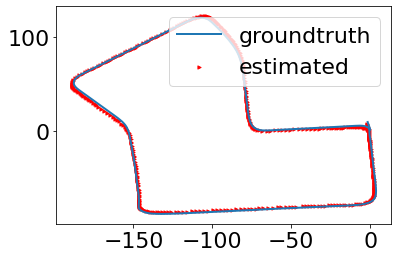

In [111]:
#Path to the times.txt in KITTI dataset
ground_time = np.loadtxt('/home/prakash/thesis_result/ORB_SLAM2_SOLOV2/kitti_07/groundtruth/times.txt')

#Path to the KeyFrameTrajectory.txt file
res_time = np.loadtxt('/home/prakash/thesis_result/ORB_SLAM_SOLOV2_moving/kitti_07/KeyFrameTrajectory_t1.txt')
#res_time = np.loadtxt('/home/prakash/git/ORB_SLAM2/KeyFrameTrajectory.txt')

#Path to the ground truth file
ground_data = np.loadtxt('/home/prakash/thesis_result/ORB_SLAM2_SOLOV2/kitti_07/groundtruth/07.txt')
data= gen_data(ground_time, res_time, ground_data)
ground_points = np.asarray(get_coo(data))
re_points = np.asarray(get_points(res_time))
# print(type(ground_points))
rot,trans,trans_error,s = align(re_points, ground_points)
# print(rot)
re_fpoints = s*rot*re_points+trans
# print(re_fpoints[0])
# print(trans_error)
#plt.scatter(ground_points[0], ground_points[2], s=0.1)
plt.scatter(list(re_fpoints[0]), list(re_fpoints[2]),s=10, marker='>', c='red', label = 'estimated')
plt.plot(ground_points[0], ground_points[2],linewidth=2,label='groundtruth')
#plt.plot((re_fpoints[0].reshape(-1)),(re_fpoints[2].reshape(-1)))
aa = list(re_fpoints[0])
x = aa[0].tolist()
aa = list(re_fpoints[2])
y = aa[0].tolist()

print ("compared_pose_pairs %d pairs"%(len(trans_error)))
print ("absolute_translational_error.rmse %f m"%np.sqrt(np.dot(trans_error,trans_error) / len(trans_error)))
print ("absolute_translational_error.mean %f m"%np.mean(trans_error))
print ("absolute_translational_error.median %f m"%np.median(trans_error))
print ("absolute_translational_error.std %f m"%np.std(trans_error))
print ("absolute_translational_error.min %f m"%np.min(trans_error))
print ("absolute_translational_error.max %f m"%np.max(trans_error))

# for num in range(len(ground_points[0])):
# 	plt.plot([ground_points[0][num], x[0][num]], [ground_points[2][num], y[0][num]], c = 'green')
plt.legend()
plt.show()

In [112]:
stage2 = re_fpoints
stage2.shape

(3, 413)

In [110]:
stage1 = re_fpoints
stage1.shape

(3, 411)

In [103]:
base = re_fpoints
base.shape

(3, 424)

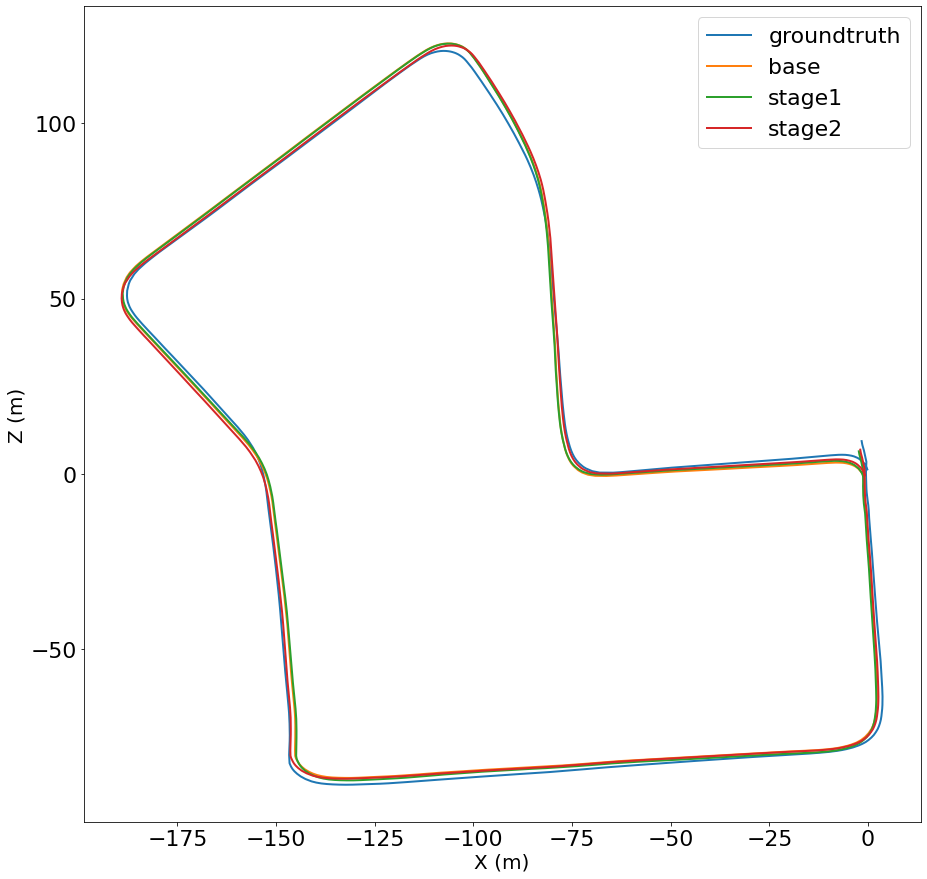

In [113]:
plt.figure (figsize=(15,15))
plt.plot(ground_points[0], ground_points[2],linewidth=2,label='groundtruth')
plt.plot(np.array(base[0]).reshape(424), np.array(base[2]).reshape(424),linewidth=2, label = 'base')
plt.plot(np.array(stage1[0]).reshape(411), np.array(stage1[2]).reshape(411),linewidth=2, label = 'stage1')
plt.plot(np.array(stage2[0]).reshape(413), np.array(stage2[2]).reshape(413),linewidth=2, label = 'stage2')
plt.rcParams.update({'font.size': 22})
plt.legend()
#plt.suptitle('KITTI sequence 05', fontsize=20)
plt.xlabel('X (m)', fontsize=20)
plt.ylabel('Z (m)', fontsize=20)
plt.show()